# Module imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from datetime import datetime

# Functions


In [ ]:
def prepend_date(filename):
    today = pd.Timestamp.today().strftime('%Y-%m-%d')
    return today + '_' + filename

# TASKS/REMINDERS:
- merge species names/taxIDs with common_names (from NCBI taxonomy)
- set hostspeciesTaxID to integer
- How to trim string entries to <92 characters?
- How to report data for certain years or releases? Can you visually display that and how?





## Code

### Load data file and format columns

In [ ]:
#Read complete data sets:  phiSlim: the complete data set with 30 columns
url = 'https://raw.githubusercontent.com/martin2urban/phi4statsPy/main/phiSlim30cols.csv'
column_names= ['PhiAcc', 'ProtId', 'PathSpecies', 'PathSpeciesTaxID', 'Phenotype', 'Literature_Id', 'Year_published', 'HostSpeciesTaxId', 'DiseaseName']
my_types = {
    "PhiAcc": "string",
    "ProtId": "string",
    "PathSpecies": "string",
    "PathSpeciesTaxID": "string",
    "Phenotype": "string",
    "Literature_Id": "string",
    "Year_published": "string",
    "HostSpeciesTaxId": "string",
    "DiseaseName": "string",
}

phiSlim = pd.read_csv(
    url,
    usecols=column_names,
    dtype=my_types,
    header=0,
    skiprows=[1],
)
phiSlim['Year_published'] = pd.to_datetime(phiSlim['Year_published'], format='%Y')    #conver year_published to datetime, function from numpy
phiSlim['PathSpeciesTaxID'] = phiSlim['PathSpeciesTaxID'].astype(str).str.strip()
phiSlim['PathSpeciesTaxID'] = phiSlim['PathSpeciesTaxID'].astype('int64')
phiSlim['Literature_Id'] = phiSlim['Literature_Id'].astype(str).str.strip()
phiSlim['Literature_Id'] = pd.to_numeric(phiSlim['Literature_Id'], errors='coerce', downcast='integer') #to numeric replace non-convertible with NaN
phiSlim['Literature_Id'] = phiSlim['Literature_Id'].fillna(0).astype(int) #replace NaN with 0, to allow int 32 data type

# Define the ordered categories for 'phenotype' column:
categories = ['unaffected pathogenicity', 'lethal', 'enhanced antagonism', 'reduced virulence', 'loss of pathogenicity',
              'increased virulence (hypervirulence)', 'effector (plant avirulence determinant)',
              'chemistry target: sensitivity to chemical', 'chemistry target: resistance to chemical']

# Convert the "Phenotype" column to dtype: category with ordered categories
phiSlim['Phenotype'] = phiSlim['Phenotype'].astype(pd.CategoricalDtype(categories=categories, ordered=True))

phiSlim.info(memory_usage="deep")  #calculates memory usage including strings
#phiSlim.to_csv(('phiSlim.csv'), index=False)


In [ ]:
# Define the ordered categories
categories = ['unaffected pathogenicity', 'lethal', 'enhanced antagonism', 'reduced virulence', 'loss of pathogenicity',
              'increased virulence (hypervirulence)', 'effector (plant avirulence determinant)',
              'chemistry target: sensitivity to chemical', 'chemistry target: resistance to chemical']

# Convert the "Phenotype" column to dtype: category with ordered categories
phiSlim['Phenotype'] = phiSlim['Phenotype'].astype(pd.CategoricalDtype(categories=categories, ordered=True))


# Make stats-counts reports and save to files

In [ ]:
#  Make global stats counts for phiSlim
column_names = ['PhiAcc', 'PathSpecies', 'ProtId', 'HostSpeciesTaxId', 'Literature_Id', 'DiseaseName']
aggregations = {'PhiAcc': 'count', 'PathSpecies': 'nunique', 'ProtId': 'nunique', 'HostSpeciesTaxId': 'nunique', 'Literature_Id': 'nunique', 'DiseaseName': 'nunique'}
global_data = phiSlim[column_names].agg(aggregations).reset_index()
global_data    #needs write statement

In [ ]:
from IPython.core.interactiveshell import InteractiveShell     #dipslay all outputs from this cell
InteractiveShell.ast_node_interactivity = 'all'               #dipslay all outputs from this cell

# make stats-counts report
# 1==================================================================
# tabulate tally: species x genes x interactions
# Group by 'PathSpecies' and calculate distinct 'PhiAcc' count and count of rows
data = phiSlim.groupby('PathSpecies').agg({'PhiAcc': 'nunique', 'PathSpecies': 'size'}).rename(columns={'PhiAcc': 'genes', 'PathSpecies': 'PHI.base.accession'}).reset_index()
# Sort the DataFrame by 'PHI.base.accession' in descending order
data = data.sort_values('PHI.base.accession', ascending=False)
data = data.rename(columns={'PHI.base.accession': 'interactions'})  # Rename 'PHI.base.accession' column to 'interactions'
data.reset_index(drop=True) # Reset index and drop the old index column
data.to_csv(prepend_date('phiSlim_speciesBYpathogen_geneBYinteraction_tally.csv'), index=False)   #write dataframe to csv
# 2==================================================================
# Report number of species per genus
# Split data "species name
data2 = data['PathSpecies'].str.split(' ', expand=True).rename(columns={0: 'genus', 1: 'species'})
data2 = data2.iloc[:, [0, 1]]
# Group by genus and count distinct species
data3 = data2.groupby('genus').agg(Species=('species', 'nunique')).reset_index()
# Sort by descending species count
data3 = data3.sort_values('Species', ascending=False)
data3.reset_index(drop=True)  #drop = True drops the current index and resets the index to start at 0
# Write to CSV
#data3.to_csv(pd.Timestamp.today().strftime('%Y-%m-%d') +'_phiSlim_genus_no_Species.csv', index=False)

In [ ]:
#This code groups the phi DataFrame by the 'PathSpecies' column, counts the occurrences of each 'PathSpecies' value using size(), and then sorts the result in descending order using sort_values().
tally = phiSlim.groupby('PathSpecies').size().reset_index(name='n')
# Tally all pathogens and  interactions and save csv file: phi_tally_all_pathog&interact,csv
tally.rename(columns={'PathSpecies': 'Tally-All-PathSpecies'}, inplace=True)
tally.index = tally.index + 1
tally
tally.to_csv(prepend_date('phi_tally_all_pathog&interact.csv'))
# Tally the top30 pathogens
top30 = tally.sort_values(by='n', ascending=False).head(30).reset_index(drop=True)
top30.rename(columns={'Tally-All-PathSpecies': 'Top30-PathSpecies'}, inplace=True)
top30.index = top30.index + 1
top30

## Graphical data display of dataframe phiSlim

In [ ]:
import matplotlib.pyplot as plt
# Group by 'Year_published' and count unique 'Literature_Id'
unique_literature_counts = phiSlim.groupby('Year_published')['Literature_Id'].nunique()
# Calculate the cumulative sum of unique 'Literature_Id'
cumulative_sum = unique_literature_counts.cumsum()
# Plotting the line graph with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot the number of unique Literature_Ids on the first y-axis
ax1.plot(unique_literature_counts.index, unique_literature_counts, marker='o', color='b', label='Unique Literature_Ids')
ax1.set_xlabel('Year_published')
ax1.set_ylabel('Number of Unique Literature_Ids', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)
# Create a second y-axis for the cumulative sum
ax2 = ax1.twinx()
ax2.plot(cumulative_sum.index, cumulative_sum, marker='s', color='r', label='Cumulative Sum')
ax2.set_ylabel('Cumulative Sum of Literature_Ids', color='r')
ax2.tick_params('y', colors='r')
# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of Unique Literature_Ids and Cumulative Sum Over Year_published')
plt.show()



## Summarise data by phylum =>TAB 1

In [ ]:
# Summarise data by phylum
king_cols = ['PathSpeciesTaxID', 'Phylum_pathogen']
pathSpecies = pd.read_csv(
    'metadata/pathSpecies_lifestyles.csv',
    usecols = king_cols,
)
pathSpecies['Phylum_pathogen'] = pathSpecies['Phylum_pathogen'].astype('string').astype('category')
pathSpecies['Phylum_pathogen'].value_counts()

In [ ]:
merged_df.columns

In [ ]:
# uses LEFT JOIN ON DATAFRAMES
phiSlim['PathSpeciesTaxID'] = phiSlim['PathSpeciesTaxID'].astype('int64')
merged_df = pd.merge(phiSlim, pathSpecies, on='PathSpeciesTaxID', how='left')
merged_df.groupby(['Phylum_pathogen', 'Phenotype']).agg({'PhiAcc': 'count'}).reset_index()


In [ ]:
# restructure to wide format
merged_df.pivot_table(index='Phylum_pathogen', columns='Phenotype', values='PhiAcc', aggfunc='count')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: effector (plant avirulence determinant)')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: loss of pathogenicity')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: reduced virulence')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: unaffected pathogenicity')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: lethal')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: increased virulence (hypervirulence)')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: chemistry target: resistance to chemical')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: chemistry target: sensitivity to chemical')

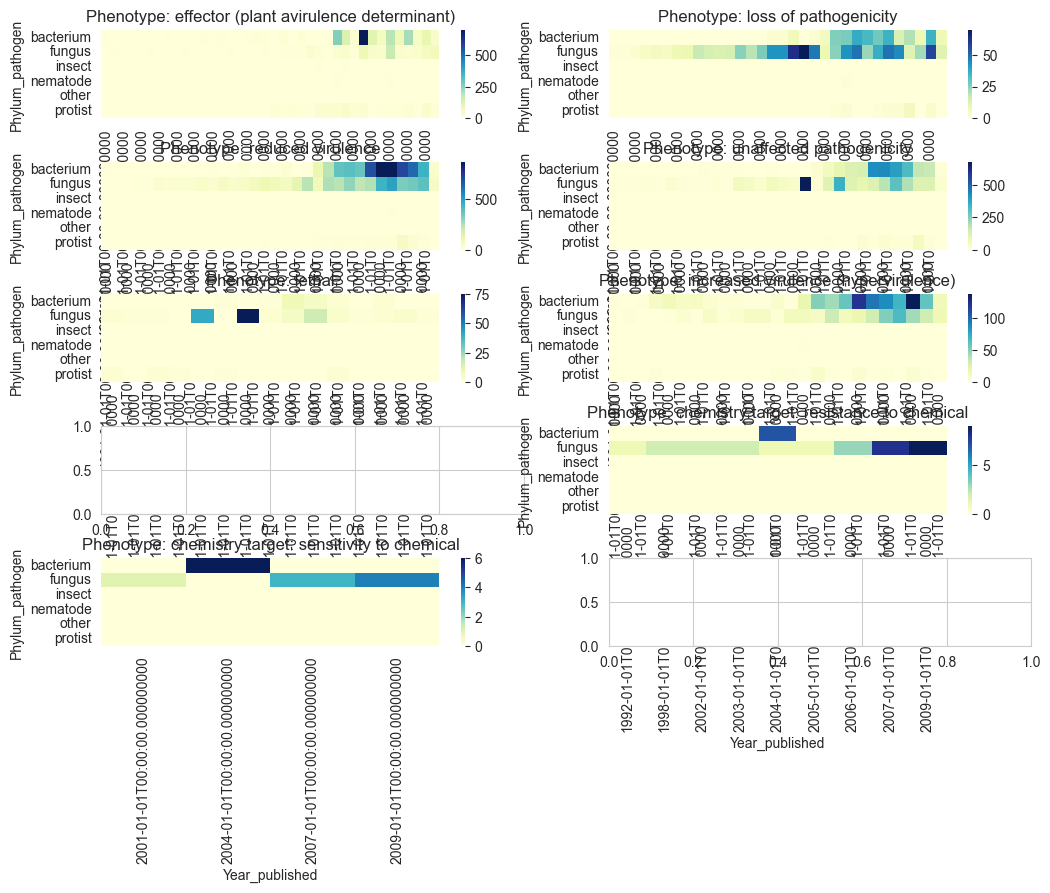

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique Phenotype categories
phenotypes = merged_df['Phenotype'].unique()

# Determine the number of rows and columns for subplots
num_rows = int(len(phenotypes) / 2) + len(phenotypes) % 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate over unique Phenotype categories and create heatmaps
for i, phenotype in enumerate(phenotypes):
    row = i // num_cols
    col = i % num_cols
    subset_df = merged_df[merged_df['Phenotype'] == phenotype]
    pivot_df = subset_df.pivot_table(index='Phylum_pathogen', columns='Year_published', values='PhiAcc', aggfunc='count')

    if pivot_df.size > 0:  # Check if the DataFrame is not empty
        sns.heatmap(pivot_df, cmap='YlGnBu', ax=axes[row, col])
        axes[row, col].set_title(f'Phenotype: {phenotype}')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the combined graph
plt.show()

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: effector (plant avirulence determinant)')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: loss of pathogenicity')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: reduced virulence')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: unaffected pathogenicity')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: lethal')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: increased virulence (hypervirulence)')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: chemistry target: resistance to chemical')

<Axes: xlabel='Year_published', ylabel='Phylum_pathogen'>

Text(0.5, 1.0, 'Phenotype: chemistry target: sensitivity to chemical')

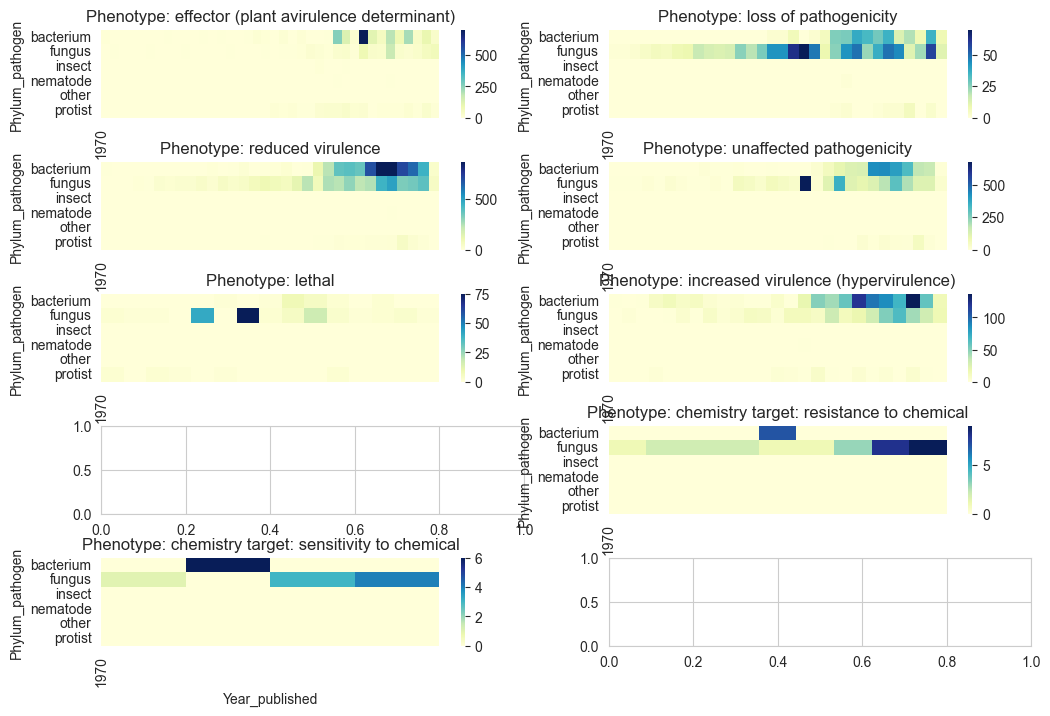

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

# Get unique Phenotype categories
phenotypes = merged_df['Phenotype'].unique()

# Determine the number of rows and columns for subplots
num_rows = int(len(phenotypes) / 2) + len(phenotypes) % 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate over unique Phenotype categories and create heatmaps
for i, phenotype in enumerate(phenotypes):
    row = i // num_cols
    col = i % num_cols
    subset_df = merged_df[merged_df['Phenotype'] == phenotype]
    pivot_df = subset_df.pivot_table(index='Phylum_pathogen', columns='Year_published', values='PhiAcc', aggfunc='count')

    if pivot_df.size > 0:  # Check if the DataFrame is not empty
        sns.heatmap(pivot_df, cmap='YlGnBu', ax=axes[row, col])
        axes[row, col].set_title(f'Phenotype: {phenotype}')

        # Reformat the year axis
        axes[row, col].xaxis.set_major_locator(YearLocator())
        axes[row, col].xaxis.set_major_formatter(DateFormatter('%Y'))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the combined graph
plt.show()

In [ ]:
#STOP


In [ ]:
# Snippets beneath this point